<a href="https://colab.research.google.com/github/krispudzian/Draft6G/blob/main/DraftGame6G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
from bs4 import BeautifulSoup, Comment

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os

# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from oauth2client.client import GoogleCredentials

# gc = gspread.authorize(GoogleCredentials.get_application_default())

# DRAFT_LIST = 'https://docs.google.com/spreadsheets/d/1oL2T1ZBoMrRt7aD3kpgHuiRpFHzl5wfgdX3K5eMjsCo/edit#gid=0'
# gs_draft_list = gc.open_by_url(DRAFT_LIST)

Getting the list of draft picks in the game

In [2]:
# draft_list = pd.DataFrame(gs_draft_list.sheet1.get_all_records())
# draft_list = draft_list.iloc[146:]
draft_list = pd.read_excel("./DraftList.xlsx")
draft_list.tail()

,Pick,Team,Name,Season
145,146,Sadło Charlesa Barkley'a,Mike Bibby,2005-06
146,147,Obiboki,Antonio McDyess,1997-98
147,148,Ball So Hard University,Jerry Stackhouse,2000-01
148,149,Okrutni Siepacze Zła,Patrick Beverley,2016-17
149,150,Wojownicze Truskawki,Leandro Barbossa,2006-07


### TODO: Add some description, how those links are similar

In [3]:
import re

shared_names = [
                "Anthony Davis", "Ray Allen",
                "Isaiah Thomas", "Danny Green",
                "Joe Johnson", "Antoine Walker",
                "Jaylen Brown", "Kemba Walker",
                "Rashard Lewis", "Wesley Matthews",
                "Jaren Jackson Jr"]

def create_player_url(name):
    name_low = name.lower()     # to lowercase
    regex = re.compile('[\']')
    #First parameter is the replacement, second parameter is your input string
    name_low = regex.sub('', name_low)
    # print(name_low)
    spl = name_low.split()
    pre = spl[1][0] + "/"
    nr = "02" if name in shared_names else "01"
    end = spl[1][:5] + spl[0][:2] + nr + ".html"
    site = 'https://www.basketball-reference.com/players/'
    # print(site + pre + end)
    return site + pre + end

In [4]:
def get_year_from_season(season):
    ending = int(season[-2:])
    if ending in range(0, 21):
        return str(2000 + ending)
    return str(1900 + ending)

Getting headers from stats per game

In [5]:
def get_headers(tbl):
    headers = [h.text for h in tbl.find('thead').find_all('th')]
    headers.insert(0, "Name")
    headers.insert(1, "Pick")
    headers.insert(2, "Team")
    headers.insert(3, "Round")
    return headers

In [6]:
cat_values = ["per_game", "per_poss", "advanced"]

def get_stats(table, player, category, season = None):
    if season is None:
        html_row = table.find('tfoot').find('tr') 
    else:
        s_str = cat_values[category] + "." + str(season)
        html_row = table.find('tr', {'id': s_str})
    stats = [stat.text for stat in html_row]
    stats.insert(0, player['Name'])
    stats.insert(1, player['Pick'])
    stats.insert(2, player['Team'])
    stats.insert(3, (player['Pick'] - 1) // 30 + 1)
    return stats

Converting numerical stats to floats. I don't know if I still need this function, because I can convert the values later using `pd.to_numeric()`

In [7]:
def stats_to_numbers(stats):
    num_stats = []
    for stat in stats:
        try:
            stat = float(stat)
        except Exception:
            pass
        num_stats.append(stat)
    return num_stats

This is a tricky part. I don't know why, but for the stats per 100 posessions I don't see the table, that I need. It exists on the website, but `find('table')` returns a `NoneType`. However, what's really interesting, there is a comment, that contains the whole missing html structure. I have no idea if it is done on purpose, but it is not my concern. 

In [8]:
def get_stat_table(site, attrs):
    div = site.find(attrs = attrs)
    table = div.find('table')
    if table is None:
        # print("Scraping from a comment")
        com = None
        for c in div:
            if isinstance(c, Comment):
                com = c
                break
        com_html = BeautifulSoup(com, 'html.parser')
        return com_html.find('table')
    return table

Defining tables to store stats. There are 3 types of stats, that will be used in this project:
1.   Per game
2.   Per 100 Possessions
3.   Advanced



In [9]:
per_game = []
per_poss = []
advanced = []

In [10]:
def add_player_stats(player):
    print("{} - {}".format(player['Pick'], player['Name']))
    url = create_player_url(player['Name'])
    season = get_year_from_season(player['Season'])
    player_site = urllib.request.urlopen(url).read()
    site_content = BeautifulSoup(player_site, "html.parser")

    # Create another function for those
    # div_per_game = site_content.find(attrs={'id': 'all_per_game'})
    tbl_per_game = get_stat_table(site_content, {'id': 'all_per_game'})
    if not per_game:
        headers_per_game = get_headers(tbl_per_game)
        per_game.append(headers_per_game)
    stats = get_stats(tbl_per_game, player, 0, season)
    per_game.append(stats)

    # div_per_poss = site_content.find(attrs={'id': 'all_per_poss'})
    tbl_per_poss = get_stat_table(site_content, {'id': 'all_per_poss'})
    if not per_poss:
        headers_per_poss = get_headers(tbl_per_poss)
        per_poss.append(headers_per_poss)
    stats = get_stats(tbl_per_poss, player, 1, season)
    per_poss.append(stats)

    tbl_adv = get_stat_table(site_content, {'id': 'all_advanced'})
    if not advanced:
        headers_adv = get_headers(tbl_adv)
        advanced.append(headers_adv)
    stats = get_stats(tbl_adv, player, 2, season)
    advanced.append(stats)


In [11]:
draft_list.apply(add_player_stats, axis=1)
# short = draft_list[:5]
# short.apply(add_player_stats, axis=1)

1 - Steve Nash
2 - LeBron James
3 - Stephen Curry
4 - Tim Duncan
5 - Kobe Bryant
6 - Giannis Antetokounmpo
7 - Kevin Durant
8 - Kevin Garnett
9 - Kawhi Leonard
10 - Luka Doncic
11 - Allen Iverson
12 - Dirk Nowitzki
13 - Chris Paul
14 - Dwyane Wade
15 - Marc Gasol
16 - Anthony Davis
17 - James Harden
18 - Ben Wallace
19 - Vince Carter
20 - Tracy McGrady
21 - Kyrie Irving
22 - Damian Lillard
23 - Dwight Howard
24 - Derrick Rose
25 - Russel Westbrook
26 - Paul Pierce
27 - Manu Ginobili
28 - Paul George
29 - Carmelo Anthony
30 - Chauncey Billups
31 - Joel Embiid
32 - Ray Allen
33 - Klay Thompson
34 - Tony Parker
35 - Nikola Jokic
36 - Pau Gasol
37 - Chris Bosh
38 - Brandon Roy
39 - Yao Ming
40 - Jimmy Butler
41 - DeMarcus Cousins
42 - Deron Williams
43 - Victor Oladipo
44 - Draymond Green
45 - Gilbert Arenas
46 - Elton Brand
47 - Serge Ibaka
48 - Kevin Love
49 - Ron Artest
50 - Jason Tatum
51 - Joakim Noah
52 - Shawn Marion
53 - Bradley Beal
54 - Rudy Gobert
55 - Zion Williamson
56 - Blake

0      None
1      None
2      None
3      None
4      None
       ... 
145    None
146    None
147    None
148    None
149    None
Length: 150, dtype: object

In [12]:
spg = pd.DataFrame(per_game)
# use the first row as column names
spg.columns = spg.iloc[0]
spg = spg.iloc[1:]
# convert to numbers
spg = spg.apply(pd.to_numeric, errors='ignore')

In [13]:
spp = pd.DataFrame(per_poss)
# use the first row as column names
spp.columns = spp.iloc[0]
spp = spp.iloc[1:]
# convert to numbers
spp = spp.apply(pd.to_numeric, errors='ignore')

In [14]:
adv = pd.DataFrame(advanced)
# use the first row as column names
adv.columns = adv.iloc[0]
adv = adv.iloc[1:]
# convert to numbers
adv = adv.apply(pd.to_numeric, errors='ignore')

In [15]:
adv

,Name,Pick,Team,Round,Season,Age,Tm,Lg,Pos,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
1,Steve Nash,1,Sebastian Bielas,1,2004-05,30,PHO,NBA,PG,75,2573,22.0,0.606,0.254,0.278,2.5,7.6,5.2,49.2,1.4,0.2,20.3,20.5,NaN,9.7,1.2,10.9,0.203,NaN,5.5,-0.8,4.7,4.4
2,LeBron James,2,BratyBe,1,2012-13,28,MIA,NBA,PF,76,2877,31.6,0.640,0.188,0.395,4.4,20.8,13.1,36.4,2.4,1.9,12.4,30.2,NaN,14.6,4.7,19.3,0.322,NaN,9.3,2.4,11.7,9.9
3,Stephen Curry,3,Między Rondem a Palmą,1,2015-16,27,GSW,NBA,PG,79,2700,31.5,0.669,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,NaN,13.8,4.1,17.9,0.318,NaN,10.3,1.6,11.9,9.5
4,Tim Duncan,4,Maciej Staszewski,1,2002-03,26,SAS,NBA,PF,81,3181,26.9,0.564,0.016,0.455,9.9,27.3,19.0,19.5,0.9,5.2,12.9,28.0,NaN,9.5,6.9,16.5,0.248,NaN,5.0,2.5,7.6,7.7
5,Kobe Bryant,5,Adam Szczepański,1,2008-09,30,LAL,NBA,SG,82,2960,24.4,0.561,0.196,0.329,3.5,12.8,8.2,23.8,2.1,1.0,9.7,32.2,NaN,8.6,4.0,12.7,0.206,NaN,5.6,0.3,5.9,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Mike Bibby,146,Sadło Charlesa Barkley'a,5,2005-06,27,SAC,NBA,PG,82,3167,17.9,0.554,0.360,0.292,1.1,7.7,4.4,25.2,1.4,0.2,11.3,25.4,NaN,6.0,2.4,8.4,0.127,NaN,2.7,-1.2,1.5,2.8
147,Antonio McDyess,147,Obiboki,5,1997-98,23,PHO,NBA,PF,81,2441,20.3,0.571,0.002,0.355,10.1,19.0,14.7,7.5,2.2,4.0,11.7,22.5,NaN,4.8,4.6,9.4,0.185,NaN,0.8,1.4,2.1,2.5
148,Jerry Stackhouse,148,Ball So Hard University,5,2000-01,26,DET,NBA,SG,80,3215,21.8,0.521,0.245,0.420,3.2,7.3,5.2,25.8,1.5,1.2,12.5,35.2,NaN,6.6,2.6,9.2,0.137,NaN,5.8,-0.7,5.1,5.8
149,Patrick Beverley,149,Okrutni Siepacze Zła,5,2016-17,28,HOU,NBA,SG,67,2058,13.0,0.546,0.530,0.175,5.0,15.8,10.4,18.8,2.3,1.0,14.6,14.1,NaN,2.9,2.4,5.3,0.123,NaN,-0.2,1.4,1.1,1.6


In [16]:
adv.columns

Index(['Name', 'Pick', 'Team', 'Round', 'Season', 'Age', 'Tm', 'Lg', 'Pos',
       'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', ' ', 'OWS', 'DWS', 'WS', 'WS/48', ' ',
       'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object', name=0)

In [17]:
adv.drop(adv.columns[[23, 28]], axis=1)

,Name,Pick,Team,Round,Season,Age,Tm,Lg,Pos,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
1,Steve Nash,1,Sebastian Bielas,1,2004-05,30,PHO,NBA,PG,75,2573,22.0,0.606,0.254,0.278,2.5,7.6,5.2,49.2,1.4,0.2,20.3,20.5,9.7,1.2,10.9,0.203,5.5,-0.8,4.7,4.4
2,LeBron James,2,BratyBe,1,2012-13,28,MIA,NBA,PF,76,2877,31.6,0.640,0.188,0.395,4.4,20.8,13.1,36.4,2.4,1.9,12.4,30.2,14.6,4.7,19.3,0.322,9.3,2.4,11.7,9.9
3,Stephen Curry,3,Między Rondem a Palmą,1,2015-16,27,GSW,NBA,PG,79,2700,31.5,0.669,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,13.8,4.1,17.9,0.318,10.3,1.6,11.9,9.5
4,Tim Duncan,4,Maciej Staszewski,1,2002-03,26,SAS,NBA,PF,81,3181,26.9,0.564,0.016,0.455,9.9,27.3,19.0,19.5,0.9,5.2,12.9,28.0,9.5,6.9,16.5,0.248,5.0,2.5,7.6,7.7
5,Kobe Bryant,5,Adam Szczepański,1,2008-09,30,LAL,NBA,SG,82,2960,24.4,0.561,0.196,0.329,3.5,12.8,8.2,23.8,2.1,1.0,9.7,32.2,8.6,4.0,12.7,0.206,5.6,0.3,5.9,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Mike Bibby,146,Sadło Charlesa Barkley'a,5,2005-06,27,SAC,NBA,PG,82,3167,17.9,0.554,0.360,0.292,1.1,7.7,4.4,25.2,1.4,0.2,11.3,25.4,6.0,2.4,8.4,0.127,2.7,-1.2,1.5,2.8
147,Antonio McDyess,147,Obiboki,5,1997-98,23,PHO,NBA,PF,81,2441,20.3,0.571,0.002,0.355,10.1,19.0,14.7,7.5,2.2,4.0,11.7,22.5,4.8,4.6,9.4,0.185,0.8,1.4,2.1,2.5
148,Jerry Stackhouse,148,Ball So Hard University,5,2000-01,26,DET,NBA,SG,80,3215,21.8,0.521,0.245,0.420,3.2,7.3,5.2,25.8,1.5,1.2,12.5,35.2,6.6,2.6,9.2,0.137,5.8,-0.7,5.1,5.8
149,Patrick Beverley,149,Okrutni Siepacze Zła,5,2016-17,28,HOU,NBA,SG,67,2058,13.0,0.546,0.530,0.175,5.0,15.8,10.4,18.8,2.3,1.0,14.6,14.1,2.9,2.4,5.3,0.123,-0.2,1.4,1.1,1.6


Add year for the season
Add Net Rating per 100 poss

In [18]:
spp['Year'] = spp['Season'].apply(get_year_from_season)
spp['Year'] = spp['Year'].apply(pd.to_numeric)
# do I need NetRtg?
spp['NetRtg'] = spp['ORtg'] - spp['DRtg']

20


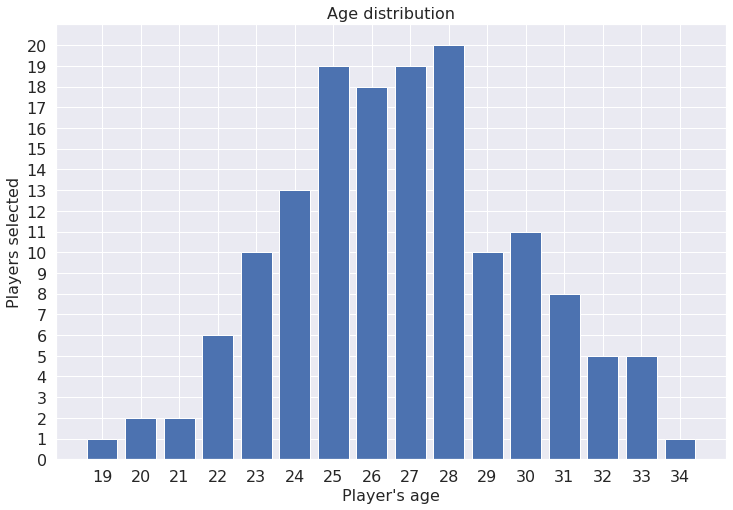

In [19]:
def plot_hist(data, title, xlabel, ylabel, rotate=False):
    # age = data['Age']
    fig, ax = plt.subplots(figsize=(12, 8))
    diff = data.max() - data.min()
    bins = diff + 1
    xticks = np.linspace(data.min(), data.max(), bins)
    hist = data.value_counts().sort_index()
    print(hist.max())
    yticks = np.linspace(0, hist.max(), hist.max()+1)
    h = pd.Series(dtype='int32')
    for tick in xticks:
        try:
            h[tick] = hist[tick]
        except KeyError:
            h[tick] = 0

    # ax.figure(figsize=(10, 8))
    ax.bar(xticks, height=h)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

    plt.xticks(xticks, rotation=45 if rotate else None)
    plt.yticks(yticks)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=16)


# tutaj byłoby dobrze dodać jeszcze może jakieś przedziały, żeby pokazać, że większość zawodników ma swój prime między 25 a 28

plot_hist(spp['Age'], "Age distribution", "Player's age", "Players selected")

20


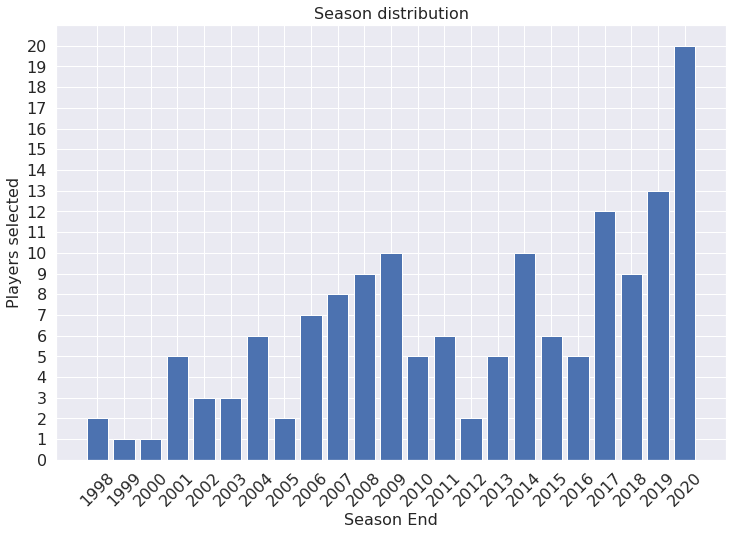

In [20]:
plot_hist(spp['Year'], "Season distribution" , "Season End", "Players selected", True)

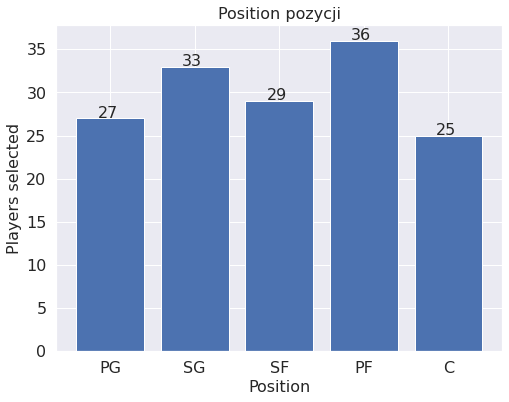

In [21]:
def plot_pos_hist(data, title, xlabel, ylabel, rotate=False):
    # age = data['Age']
    # diff = data.max() - data.min()
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = data.nunique()
    xticks = ['PG', 'SG', 'SF', 'PF', 'C']
    # xticks = data
    hist = data.value_counts().sort_index()
    h = pd.Series(dtype='int32')
    for tick in xticks:
        try:
            h[tick] = hist[tick]
        except KeyError:
            h[tick] = 0

    # ax.figure(figsize=(10, 8))
    ax.bar(xticks, height=h)

    for p in ax.patches:
        val = "{}".format(p.get_height())
        ax.text(p.get_x() + 0.25, p.get_height() + .1,  val, fontsize=16)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

    plt.xticks(xticks, rotation=45 if rotate else None)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=16)
plot_pos_hist(spp['Pos'], "Position pozycji", "Position", "Players selected")
# spp['Pos'].value_counts().plot(kind='hist')

In [22]:
spp['Pos'].value_counts()

PF    36
SG    33
SF    29
PG    27
C     25
Name: Pos, dtype: int64

In [23]:
# plot_pos_hist(spp['Tm'], "Selections by Teams", "Team", "Players selected", True)

In [24]:
spp.Tm.unique()

array(['PHO', 'MIA', 'GSW', 'SAS', 'LAL', 'MIL', 'MIN', 'TOR', 'DAL',
       'PHI', 'NOH', 'MEM', 'NOP', 'HOU', 'DET', 'ORL', 'BOS', 'POR',
       'CHI', 'OKC', 'NYK', 'DEN', 'TOT', 'UTA', 'IND', 'WAS', 'LAC',
       'SAC', 'ATL', 'CHA', 'NJN', 'VAN', 'SEA', 'CLE'], dtype=object)

In [25]:
range(1, 2)

range(1, 2)

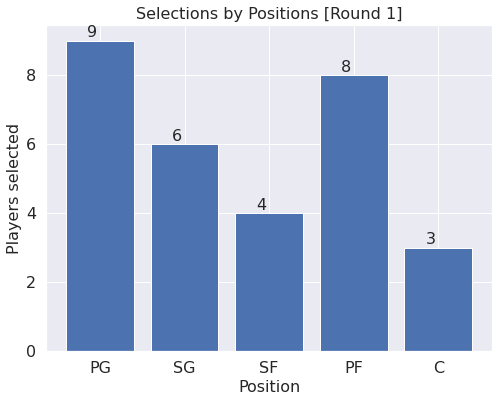

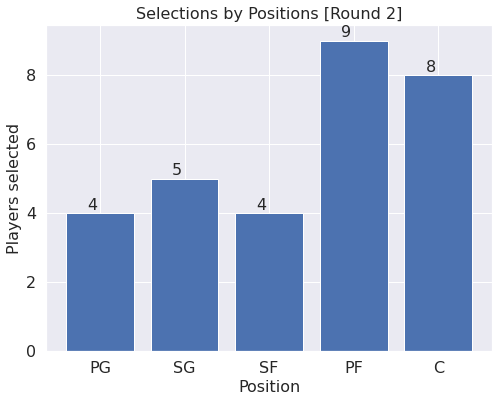

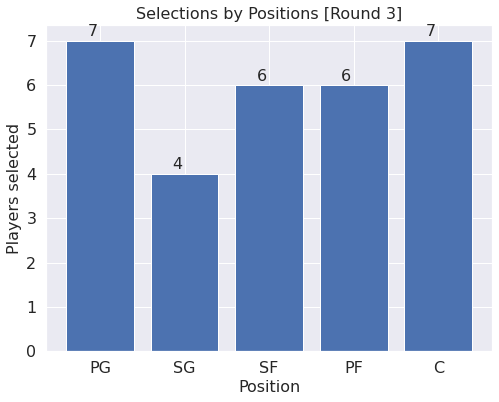

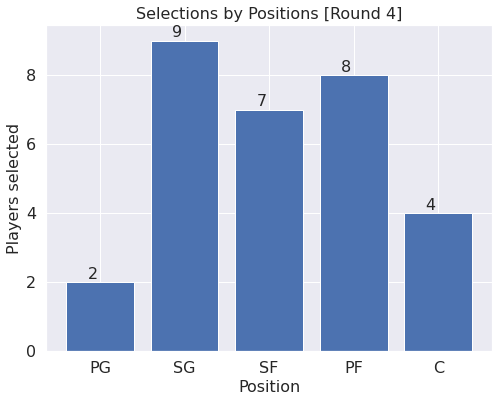

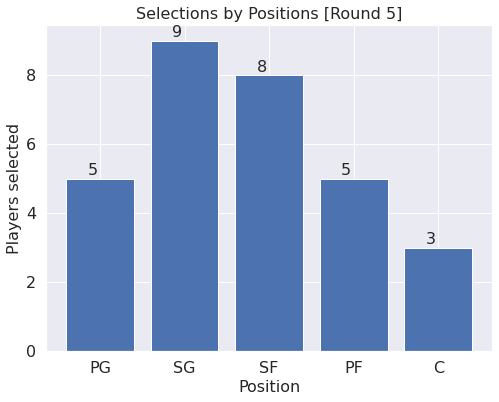

In [26]:
for i in range (1, 6):
    rnd = spp.loc[spp['Round'] == i]
    # plt.subplot(1, 2, i)
    title = "Selections by Positions [Round {}]".format(i)
    plot_pos_hist(rnd['Pos'], title, "Position", "Players selected")

In [27]:
spp.head()

,Name,Pick,Team,Round,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,,ORtg,DRtg,Year,NetRtg
1,Steve Nash,1,Sebastian Bielas,1,2004-05,30,PHO,NBA,PG,75,75,2573,8.4,16.7,0.502,1.8,4.2,0.431,6.5,12.4,0.526,4.1,4.6,0.887,1.1,3.7,4.8,16.7,1.4,0.1,4.8,2.6,22.7,NaN,123,111,2005,12
2,LeBron James,2,BratyBe,1,2012-13,28,MIA,NBA,PF,76,76,2877,14.1,24.9,0.565,1.9,4.7,0.406,12.2,20.2,0.602,7.4,9.8,0.753,1.8,9.4,11.2,10.1,2.4,1.2,4.2,2.0,37.5,NaN,125,101,2013,24
3,Stephen Curry,3,Między Rondem a Palmą,1,2015-16,27,GSW,NBA,PG,79,79,2700,14.4,28.6,0.504,7.2,15.9,0.454,7.2,12.7,0.566,6.5,7.2,0.908,1.2,6.5,7.7,9.4,3.0,0.3,4.7,2.9,42.5,NaN,125,103,2016,22
4,Tim Duncan,4,Maciej Staszewski,1,2002-03,26,SAS,NBA,PF,81,81,3181,12.0,23.3,0.513,0.1,0.4,0.273,11.9,23.0,0.517,7.5,10.6,0.710,4.3,13.1,17.5,5.3,0.9,4.0,4.2,3.9,31.6,NaN,112,94,2003,18
5,Kobe Bryant,5,Adam Szczepański,1,2008-09,30,LAL,NBA,SG,82,82,2960,13.8,29.4,0.467,2.0,5.8,0.351,11.7,23.7,0.496,8.3,9.7,0.856,1.5,5.8,7.4,6.9,2.1,0.6,3.6,3.3,37.8,NaN,115,106,2009,9


Grouping by teams and aggregating mean and sum values

In [28]:
team_mean = spp.groupby('Team').mean()
team_sum = spp.groupby('Team').sum()

In [29]:
# team_mean.sort_values('ORtg', ascending=False)['ORtg']

In [30]:
# teams.sort_values('DRtg')['DRtg']

In [31]:
# team_sum.sort_values('AST')['AST'].plot(kind="barh")

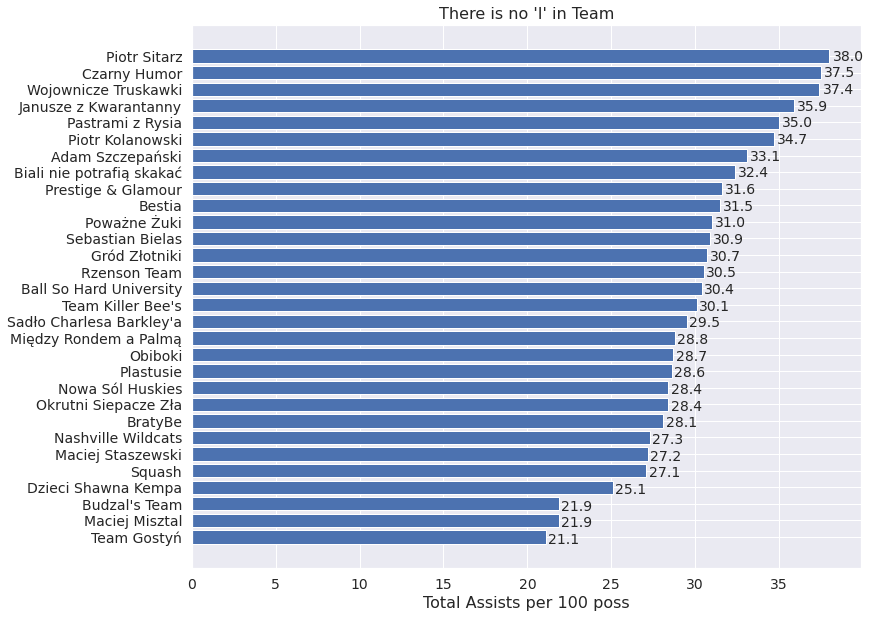

In [32]:
def plot_barh(data, col_name, title, xlabel="", add_colors=None):
    fig, ax = plt.subplots(figsize=(12, 10))
    # plt.figure(figsize=(10, 8))
    ax.barh(data.index, data[col_name])
    for p in ax.patches:
        val = "{:.1f}".format(p.get_width())
        ax.text(p.get_width() * 1.005, p.get_y() * 1.005,  val, fontsize=14)
        # ax.text()
        # print(val)
    ax.set_title(title, fontsize=16)
    if add_colors:
        for a in ax.get_children()[:5]:
            a.set_color('r')
        for a in ax.get_children()[6:11]:
            a.set_color('g')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_xlabel(xlabel, fontsize=16)

plot_barh(team_sum.sort_values('AST'), 'AST', "There is no 'I' in Team", "Total Assists per 100 poss")

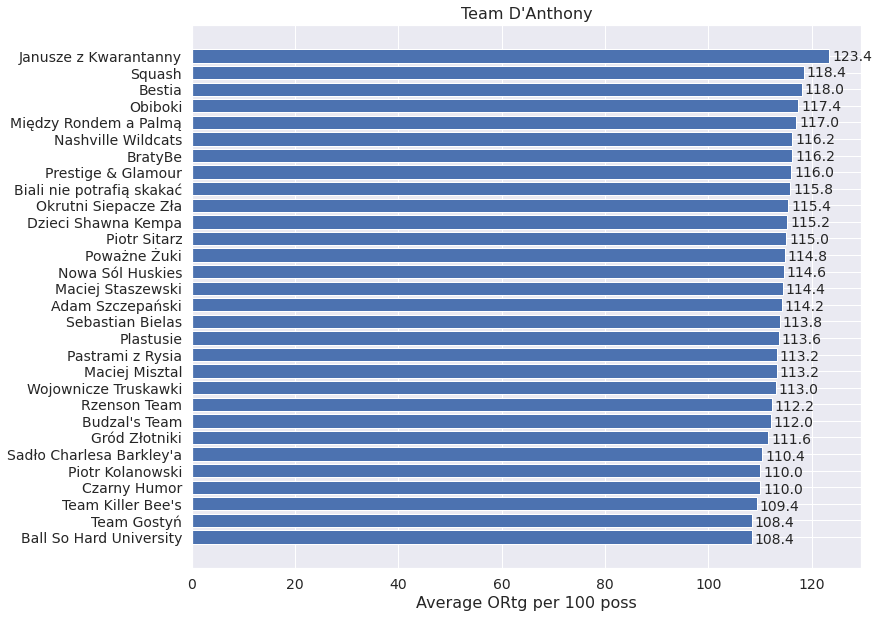

In [33]:
plot_barh(team_mean.sort_values('ORtg'), 'ORtg', "Team D'Anthony", "Average ORtg per 100 poss")

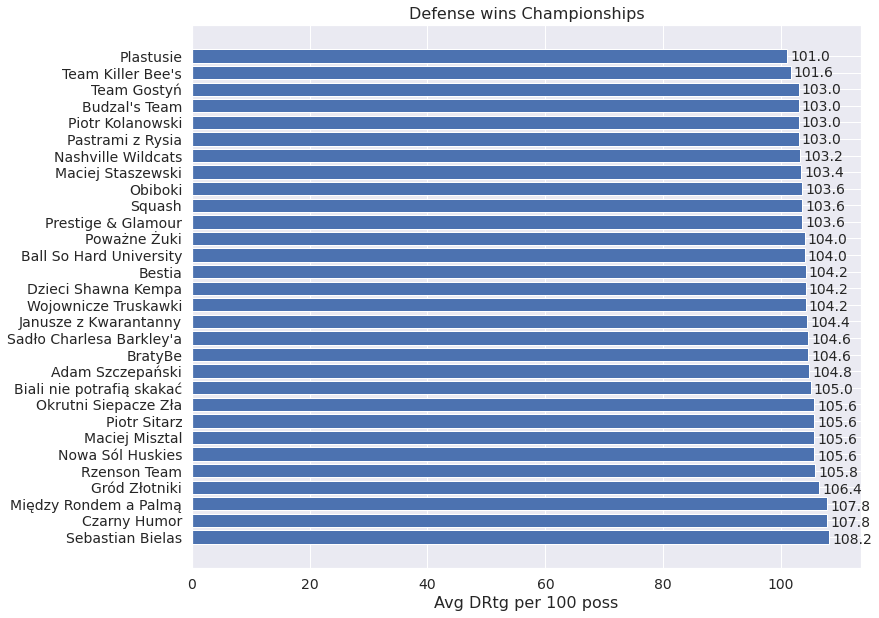

In [34]:
plot_barh(team_mean.sort_values('DRtg', ascending=False), 'DRtg', "Defense wins Championships", "Avg DRtg per 100 poss")

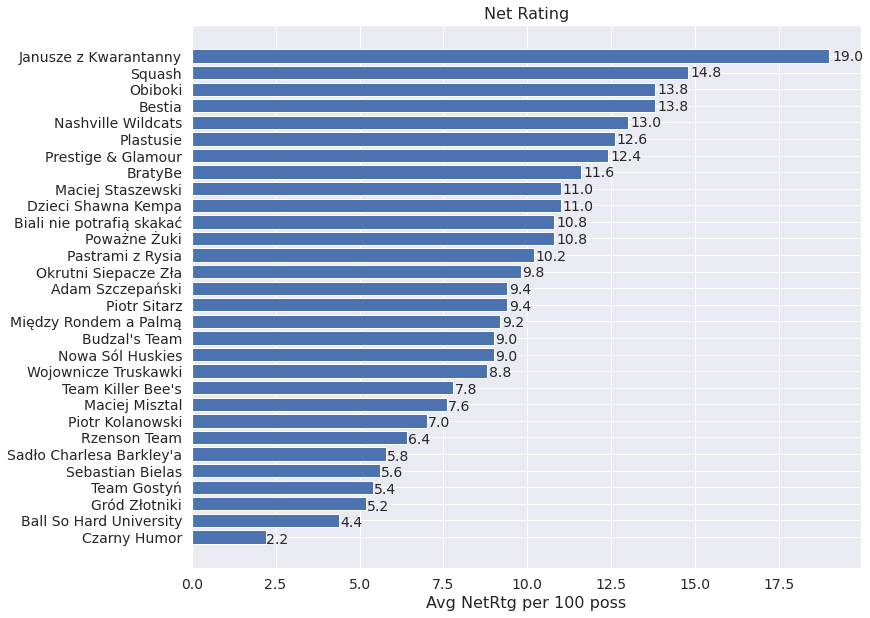

In [35]:
plot_barh(team_mean.sort_values('NetRtg'), 'NetRtg', "Net Rating", "Avg NetRtg per 100 poss")

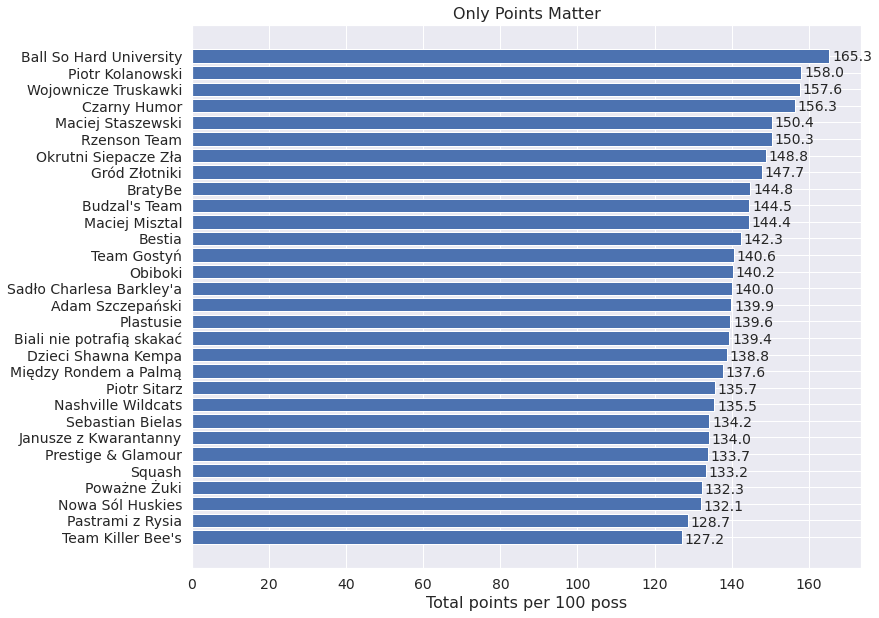

In [36]:
plot_barh(team_sum.sort_values('PTS'), 'PTS', "Only Points Matter", "Total points per 100 poss")

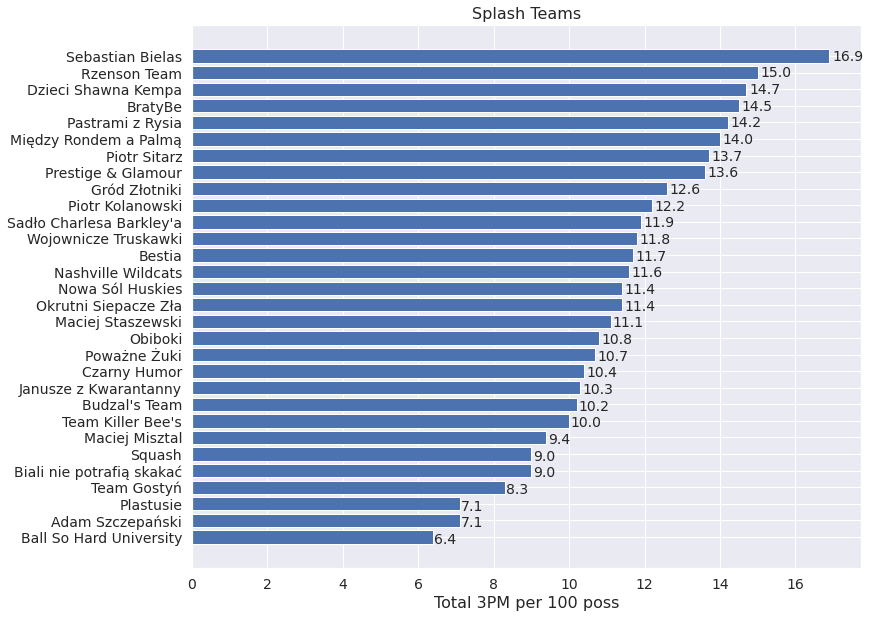

In [37]:
plot_barh(team_sum.sort_values('3P'), '3P', "Splash Teams", "Total 3PM per 100 poss")

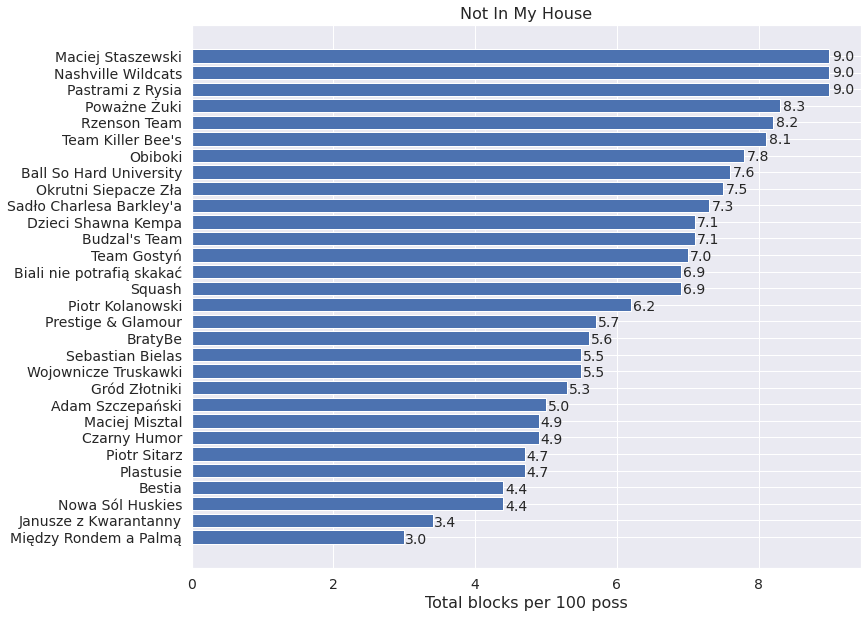

In [38]:
plot_barh(team_sum.sort_values('BLK'), 'BLK', "Not In My House", "Total blocks per 100 poss")

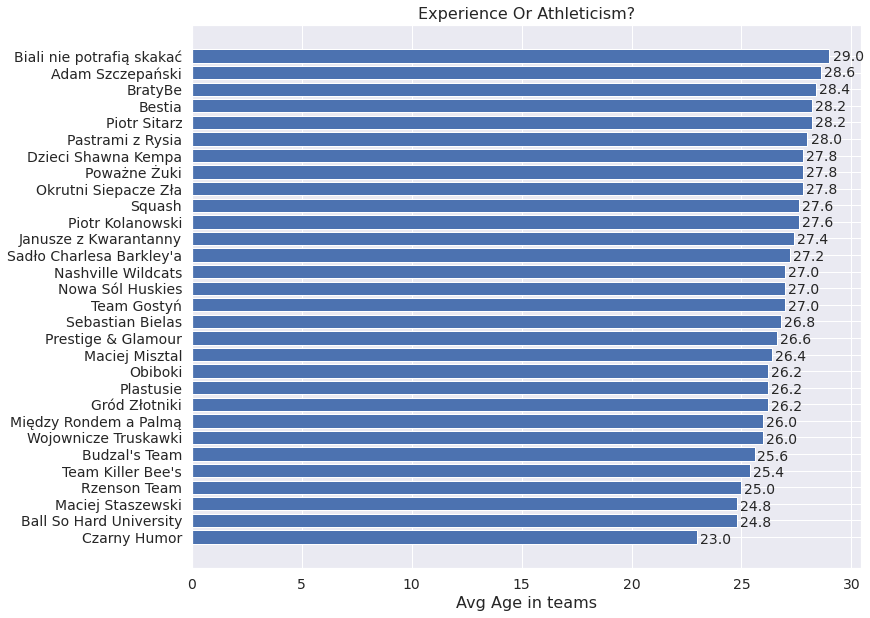

In [39]:
plot_barh(team_mean.sort_values('Age'), 'Age', "Experience Or Athleticism?", "Avg Age in teams")

In [40]:
team_sum.columns

Index(['Pick', 'Round', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '', 'ORtg', 'DRtg',
       'Year', 'NetRtg'],
      dtype='object', name=0)

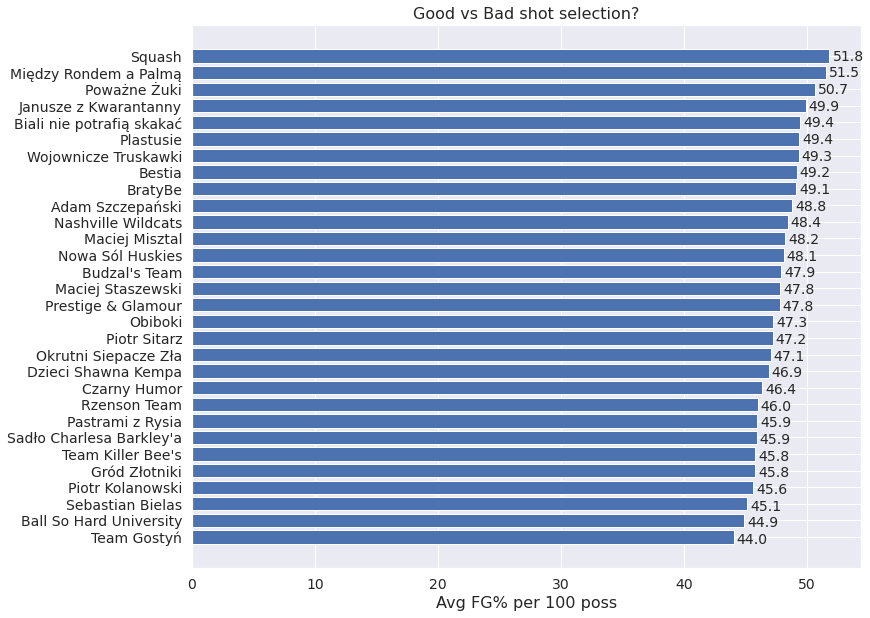

In [41]:
short = team_sum
avg_fg = short['FG'] / short['FGA'] * 100
# WARNING: I am overwriting here
team_sum['FG%'] = avg_fg
plot_barh(team_sum.sort_values('FG%'), 'FG%', "Good vs Bad shot selection?", "Avg FG% per 100 poss")

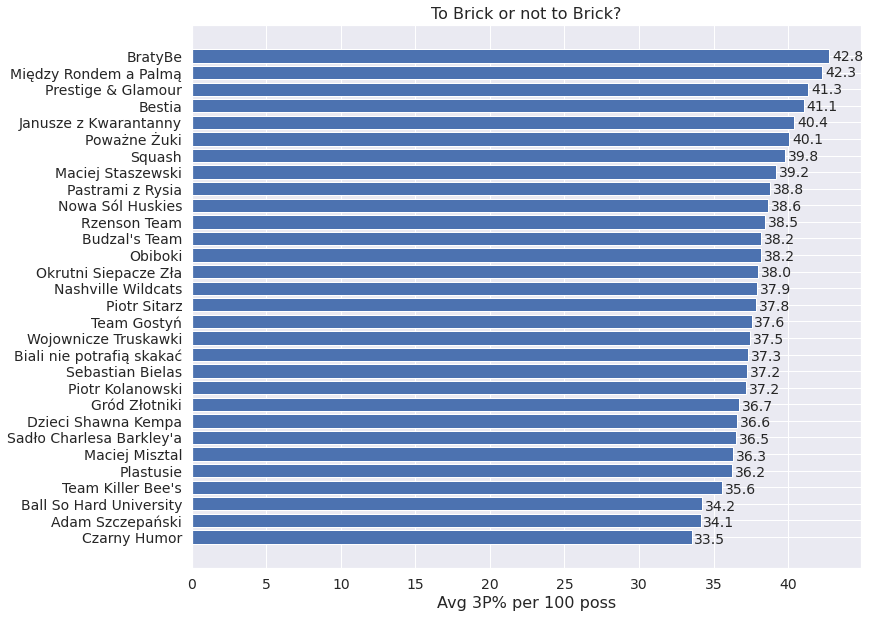

In [42]:
avg_3P = short['3P'] / short['3PA'] * 100
# WARNING: I am overwriting here
team_sum['o3P%'] = avg_3P
plot_barh(team_sum.sort_values('o3P%'), 'o3P%', "To Brick or not to Brick?", "Avg 3P% per 100 poss")

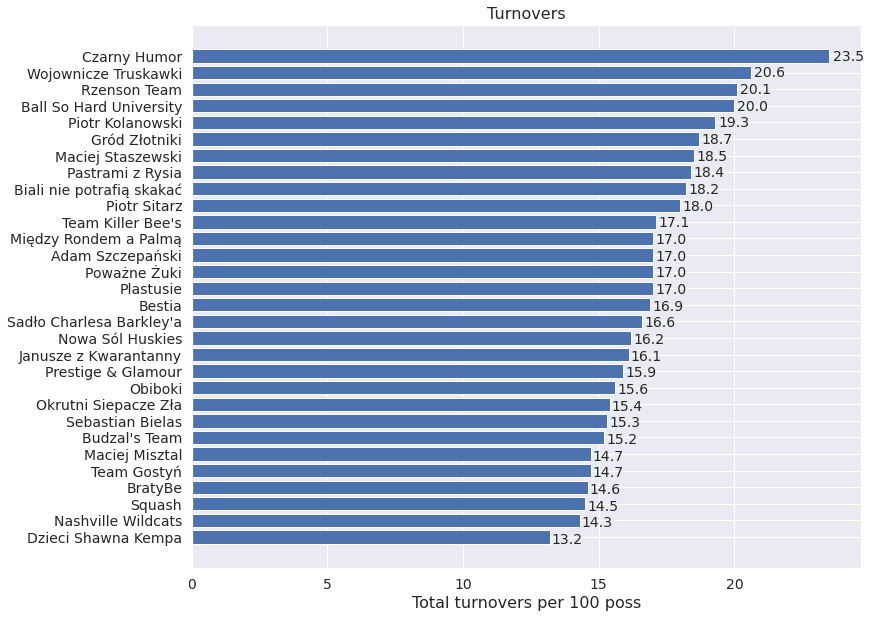

In [43]:
plot_barh(team_sum.sort_values('TOV'), 'TOV', "Turnovers", "Total turnovers per 100 poss")

In [44]:
avg = pd.DataFrame({'Name': ['Average'],
                   'PTS': [spp['PTS'].mean()],
                    'Team': ['-----']},                   
                           index=['Average'])

In [45]:
a = spp.sort_values(['PTS'])[['Name', 'PTS', 'Team']][:5]
b = spp.sort_values(['PTS'])[['Name', 'PTS', 'Team']][-5:]
c = pd.concat([a, avg, b])
c.index = c['Name']
c

,Name,PTS,Team
Name,,,
PJ Tucker,PJ Tucker,10.500,Między Rondem a Palmą
Ben Wallace,Ben Wallace,11.100,Team Killer Bee's
Bruce Bowen,Bruce Bowen,12.100,Nowa Sól Huskies
Shane Battier,Shane Battier,13.600,Obiboki
Andre Iguodala,Andre Iguodala,14.300,Squash
Average,Average,28.354,-----
James Harden,James Harden,42.300,Pastrami z Rysia
Isaiah Thomas,Isaiah Thomas,42.400,Okrutni Siepacze Zła
Stephen Curry,Stephen Curry,42.500,Między Rondem a Palmą


In [46]:
def get_tops_and_bottoms(data, column, length):
    sorted_data = data.sort_values([column])[["Name", column, "Team"]]
    sorted_data.index = sorted_data["Name"]
    avg = pd.DataFrame({'Name': ['Average'],
                   column: [data[column].mean()],
                    'Team': ['-']},                   
                           index=['Average'])
    bottoms = sorted_data[:length]
    tops = sorted_data[-length:]
    # ret_data = pd.concat([sorted_data[:length], avg, sorted_data[-length:]])
    # ret_data.index = ret_data["Name"]
    return tops, bottoms, avg

In [47]:
# test = get_tops_and_bottoms(spp, 'BLK', 3)
# test[['Name', 'BLK']]

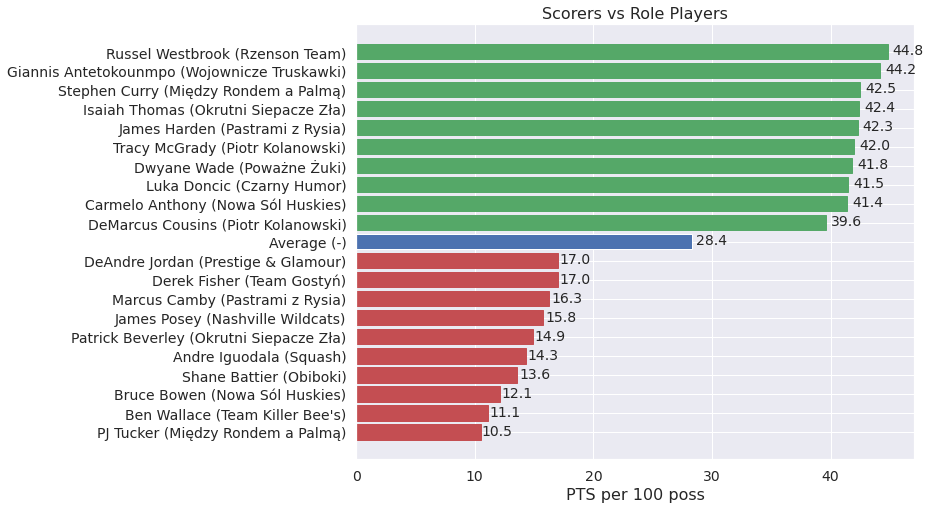

In [48]:
def players_barh(data, col_name, length, title, xlabel, only_top=False, high_prec=False):
    fig, ax = plt.subplots(figsize=(10, 8))
    # plt.figure(figsize=(10, 8))
    tops, bottoms, avg = get_tops_and_bottoms(data, col_name, length)
    if only_top:
        data_to_plot = pd.concat([avg, tops])
    else:
        data_to_plot = pd.concat([bottoms, avg, tops])
    ax.barh(data_to_plot.index, data_to_plot[col_name])
    for p in ax.patches:
        val = "{:.1f}".format(p.get_width())
        if high_prec:
            val = "{:.3f}".format(p.get_width())
        ax.text(p.get_width() * 1.01, p.get_y() + .25,  val, fontsize=14)
        # ax.text()
        # print(val)
    ax.set_title(title, fontsize=16)
    ax.set_yticklabels(data_to_plot['Name'] + " (" + data_to_plot['Team'] + ")")
    if only_top:
        for a in ax.get_children()[1: length + 1]:
            a.set_color('g')
    else:
        for a in ax.get_children()[:length]:
            a.set_color('r')
        for a in ax.get_children()[length + 1: 2*length + 1]:
            a.set_color('g')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_xlabel(xlabel, fontsize=16)
    # fig.subplots_adjust(bottom=0.1, top=0.12, left=0.12, right=0.14)
    # fig.tight_layout()

players_barh(spp, 'PTS', 10, "Scorers vs Role Players", "PTS per 100 poss")

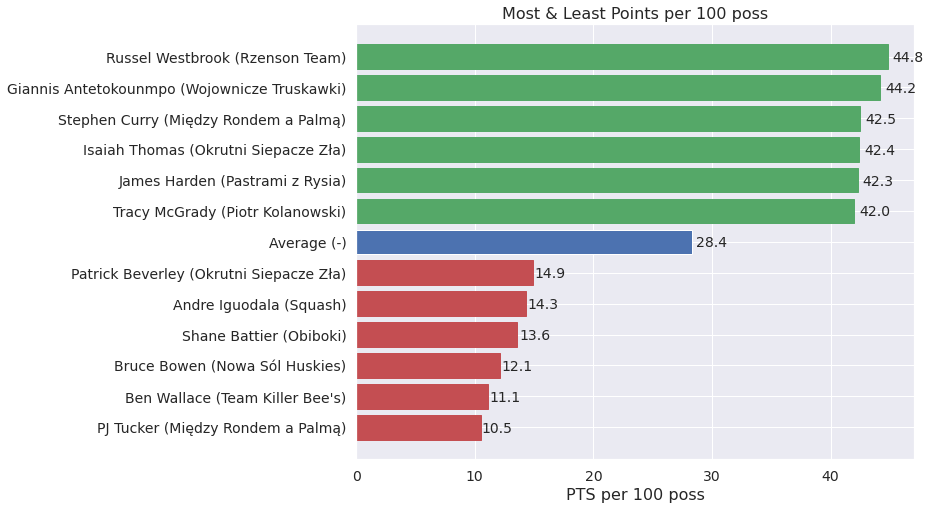

In [49]:
players_barh(spp, 'PTS', 6, "Most & Least Points per 100 poss", "PTS per 100 poss")

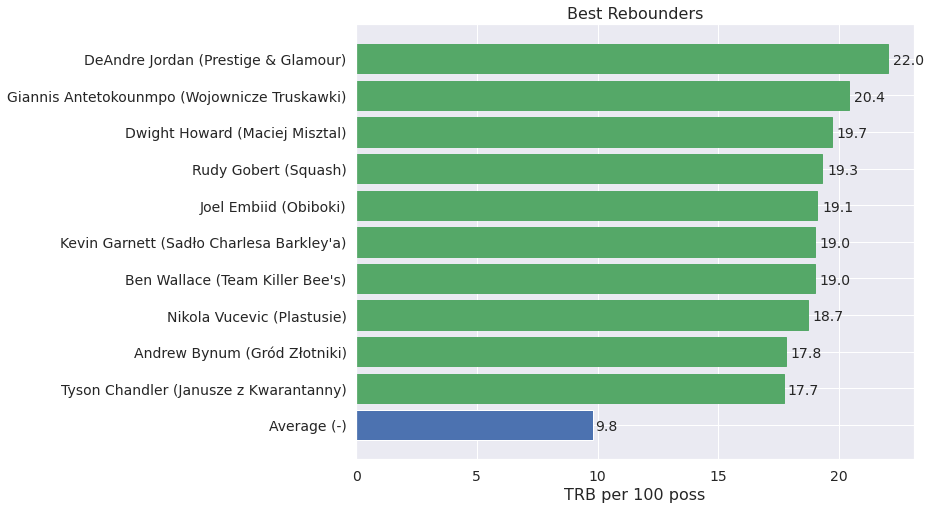

In [50]:
players_barh(spp, 'TRB', 10, "Best Rebounders", "TRB per 100 poss", True)

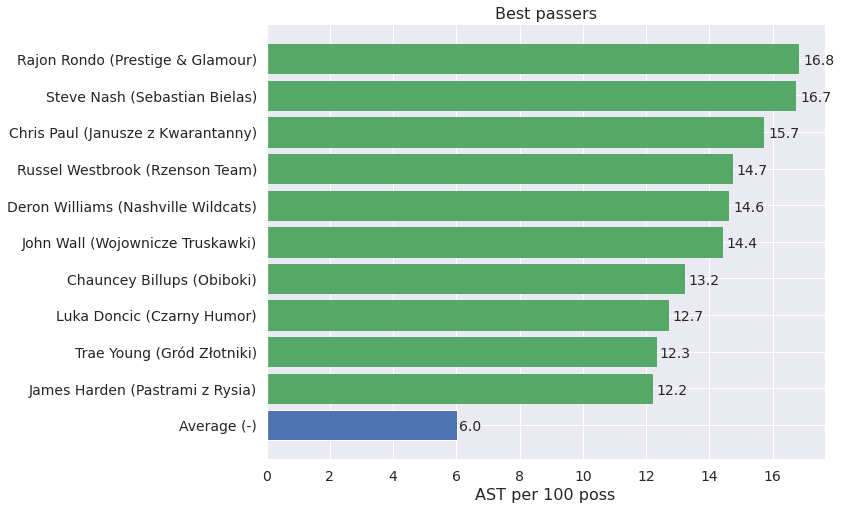

In [51]:
players_barh(spp, 'AST', 10, "Best passers", "AST per 100 poss", True)

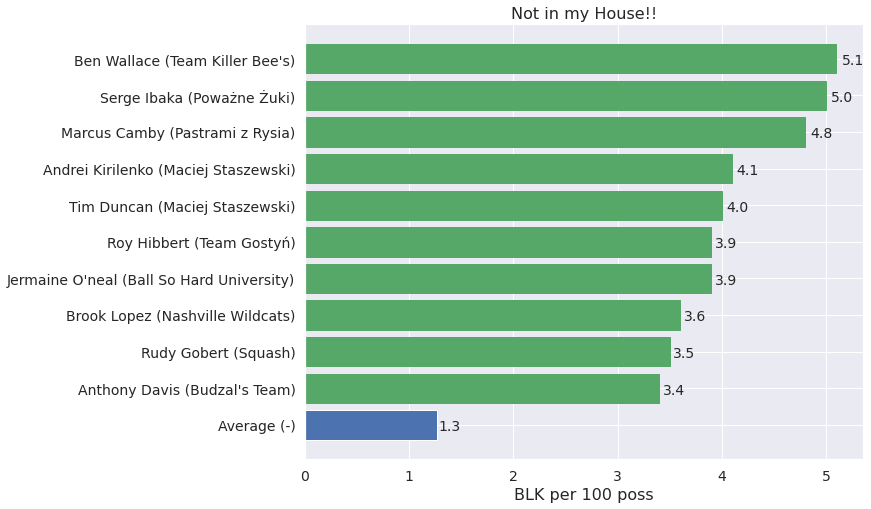

In [52]:
players_barh(spp, 'BLK', 10, "Not in my House!!", "BLK per 100 poss", True)

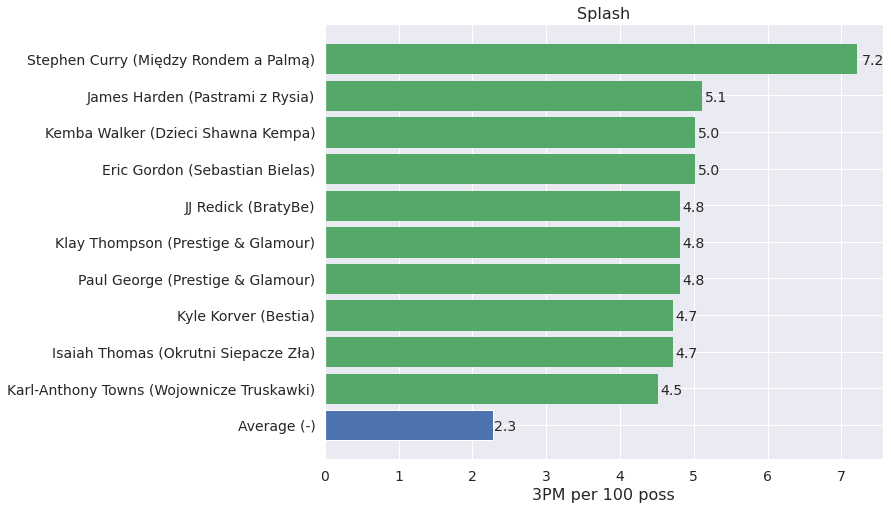

In [53]:
players_barh(spp, '3P', 10, "Splash", "3PM per 100 poss", True)

In [54]:
# players_barh(spp, '3P%', 10, "Splash", "3P% per 100 poss", True)

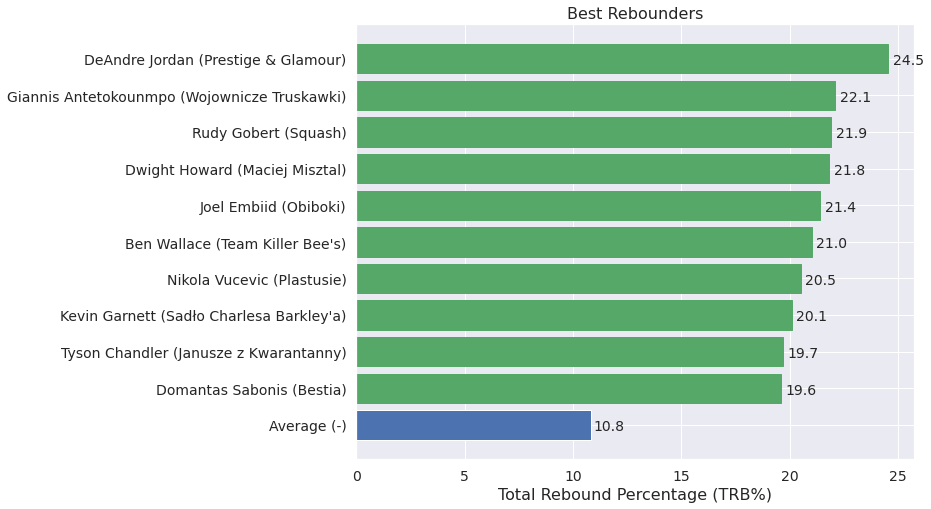

In [55]:
players_barh(adv, 'TRB%', 10, "Best Rebounders", "Total Rebound Percentage (TRB%)", True)

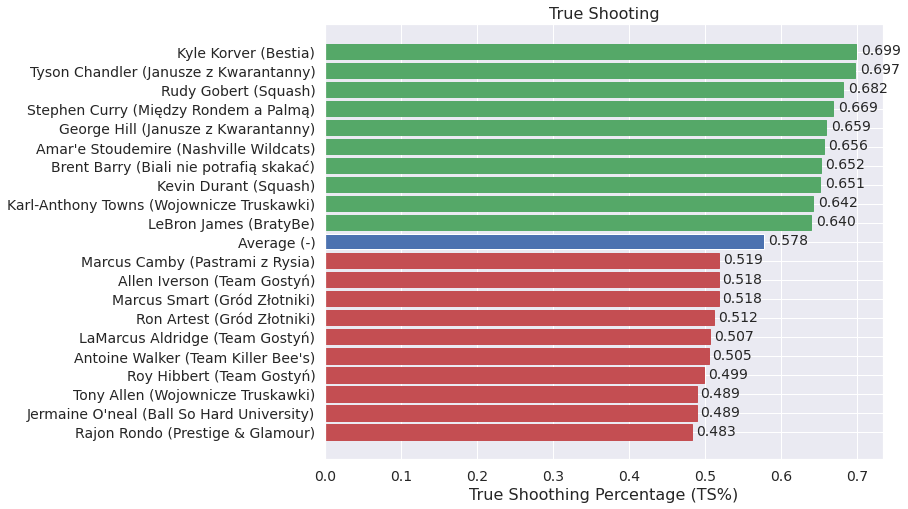

In [56]:
players_barh(adv, 'TS%', 10, "True Shooting", "True Shoothing Percentage (TS%)", False, True)

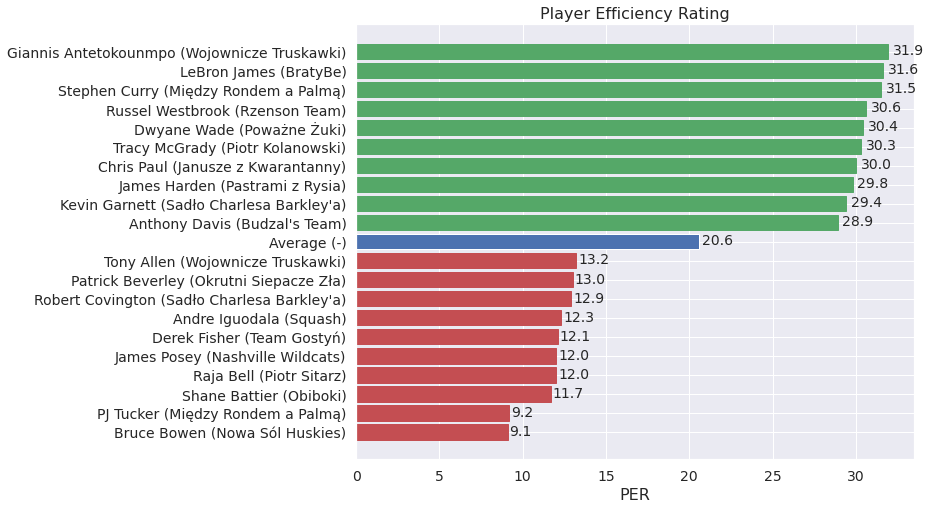

In [57]:
players_barh(adv, 'PER', 10, "Player Efficiency Rating", "PER", False)

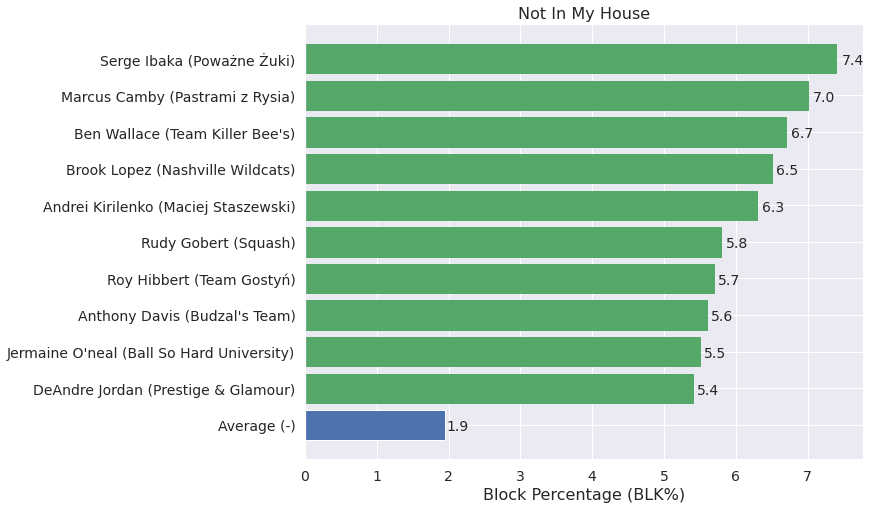

In [58]:
players_barh(adv, 'BLK%', 10, "Not In My House", "Block Percentage (BLK%)", True)

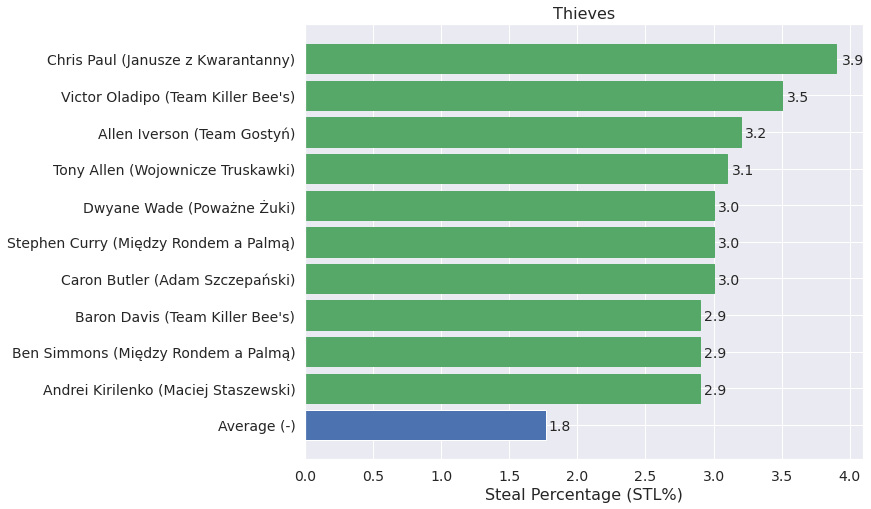

In [59]:
players_barh(adv, 'STL%', 10, "Thieves", "Steal Percentage (STL%)", True)

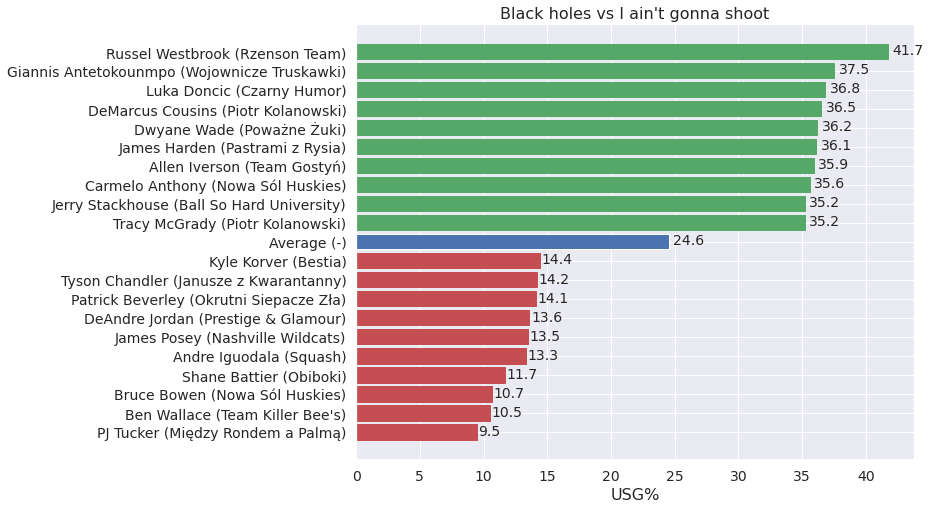

In [60]:
players_barh(adv, 'USG%', 10, "Black holes vs I ain't gonna shoot", "USG%", False)

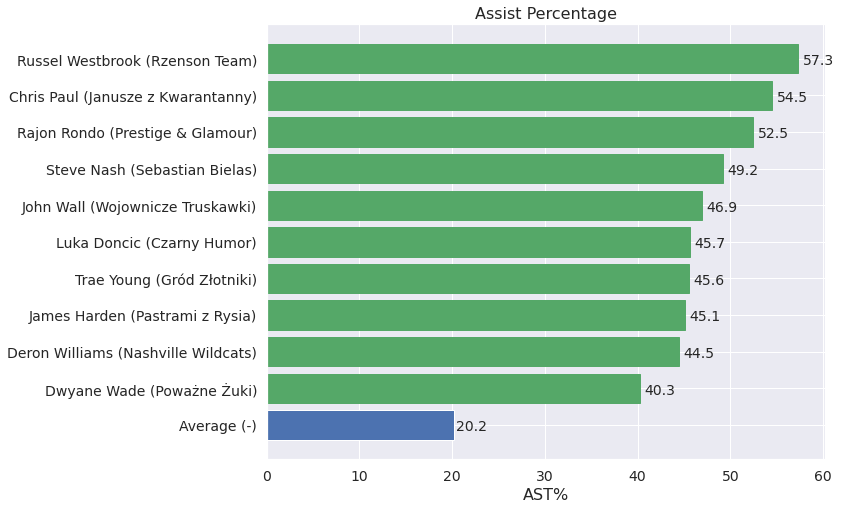

In [61]:
players_barh(adv, 'AST%', 10, "Assist Percentage", "AST%", True)

In [62]:
adv_sum = adv.groupby(['Team']).sum()

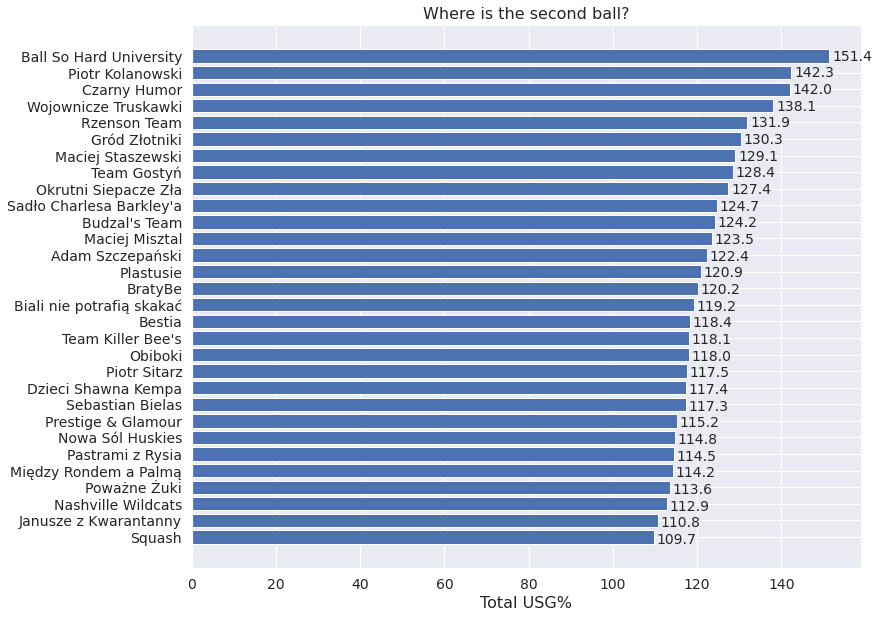

In [63]:
plot_barh(adv_sum.sort_values('USG%'), 'USG%', "Where is the second ball?", "Total USG%")

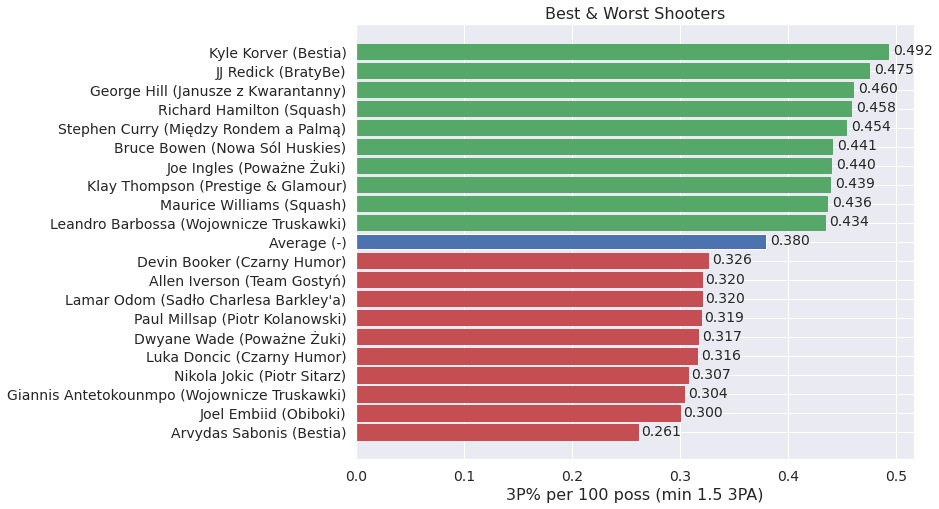

In [64]:
def plot_3ptg(data, col_name, length, title, xlabel="", add_colors=False, only_top=False, filt=False):
    fig, ax = plt.subplots(figsize=(10, 8))
    filtered = data[data['3PA'] > 1.5] if filt else data
    tops, bottoms, avg = get_tops_and_bottoms(filtered, col_name, length)
    data_to_plot = pd.concat([bottoms, avg, tops])
    ax.barh(data_to_plot.index, data_to_plot[col_name])
    for p in ax.patches:
        val = "{:.3f}".format(p.get_width())
        ax.text(p.get_width() * 1.01, p.get_y() + .25,  val, fontsize=14)
        # ax.text()
        # print(val)
    ax.set_title(title, fontsize=16)
    ax.set_yticklabels(data_to_plot['Name'] + " (" + data_to_plot['Team'] + ")")
    if add_colors :
        if only_top:
            for a in ax.get_children()[1: length + 1]:
                a.set_color('g')
        else:
            for a in ax.get_children()[:length]:
                a.set_color('r')
            for a in ax.get_children()[length + 1: 2*length + 1]:
                a.set_color('g')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_xlabel(xlabel, fontsize=16)

plot_3ptg(spp, '3P%', 10, "Best & Worst Shooters", "3P% per 100 poss (min 1.5 3PA)", True, False, True)

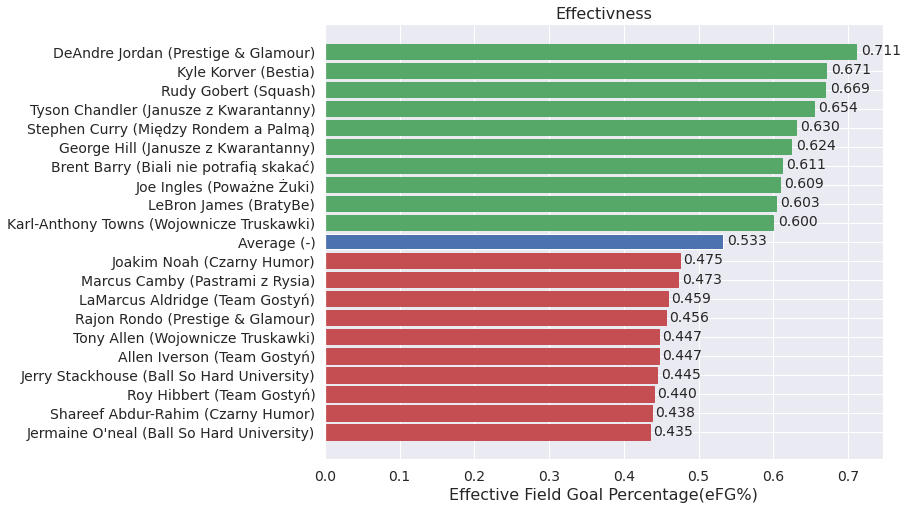

In [65]:
plot_3ptg(spg, 'eFG%', 10, "Effectivness", "Effective Field Goal Percentage(eFG%)", True)

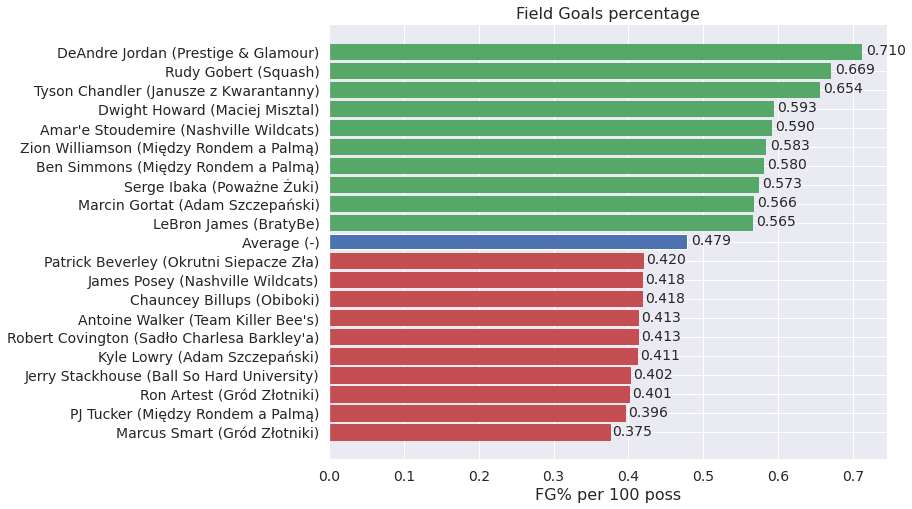

In [66]:
plot_3ptg(spp, 'FG%', 10, "Field Goals percentage", "FG% per 100 poss", True)